# Deriving the area under curve with different spans
# (Simpson's rule alternative)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap as LSCm
# from scipy.interpolate import spline 
# spline is deprecated in scipy 0.19.0, use BSpline class instead.
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d

# from scipy.interpolate import griddata
# from scipy.signal import savgol_filter
# from scipy import integrate

from NesrHydrusAnalyst import *

In [2]:
data = np.array([[0, 3.6], [25, 5.], [50, 6.5], [75, 5.5], [100, 7.3],
                 [125, 6.0], [150, 4.0]])
data

array([[0.000, 3.600],
       [25.000, 5.000],
       [50.000, 6.500],
       [75.000, 5.500],
       [100.000, 7.300],
       [125.000, 6.000],
       [150.000, 4.000]])

In [14]:
# calculate area by the original simpson's rule
h=data[1, 0]-data[0, 0]
 
borders = data[0, 1]+data[-1, 1]
odd_rows = data[::2,1][1:-1]
even_rows = data[1::2,1]
area_simp = h/3*(borders + odd_rows.sum() * 2 + even_rows.sum() * 4)
area_simp

843.3333333333334

In [74]:
def get_simpsons_area(data, h=None):
    if h is None:
        h=data[1, 0]-data[0, 0]
    borders = data[0, 1]+data[-1, 1]
    odd_rows = data[::2,1][1:-1]
    even_rows = data[1::2,1]
    area_simp = h/3*(borders + odd_rows.sum() * 2 + even_rows.sum() * 4)
    return area_simp

In [75]:
# Test
data = np.array([[0, 3.6], [25, 5.], [50, 6.5], [75, 5.5], [100, 7.3],
                 [125, 6.0], [150, 4.0]])
get_simpsons_area(data)

843.3333333333334

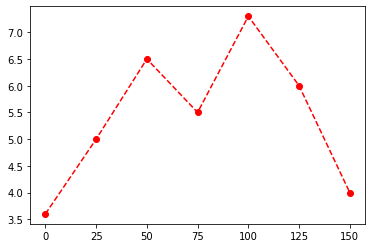

In [67]:
# Direct dotted line 
X, Y = data[:,0], data[:,1]
plt.xticks(np.arange(X.min(), X.max()+1, 25.0));
plt.plot(X, Y, 'ro--')

## Graphing The results

### From Stackoverflow 1

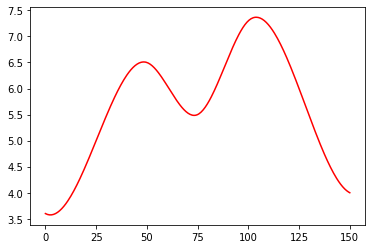

In [69]:
# Smooth curve https://stackoverflow.com/a/5284038/5820024

xnew = np.linspace(X.min(), X.max(), 300)

spl = make_interp_spline(X, Y, k=3)  # type: BSpline

power_smooth = spl(xnew)
plt.xticks(np.arange(X.min(), X.max()+1, 25.0));
plt.plot(xnew, power_smooth, 'r-');

### From Stackoverflow 2

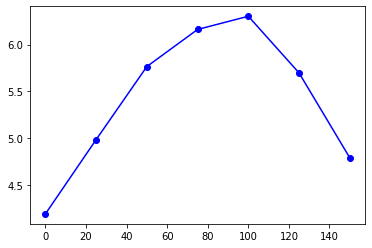

In [40]:
# Very Bad
ysmoothed = gaussian_filter1d(Y, sigma=1)
plt.plot(X, ysmoothed, 'bo-')

### Trials from Scipy examples

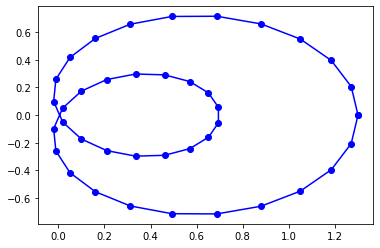

In [32]:
phi = np.linspace(0, 2.*np.pi, 40)
r = 0.3 + np.cos(phi)
x, y = r*np.cos(phi), r*np.sin(phi) 
plt.plot(x, y, 'bo-');

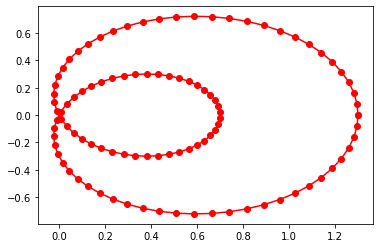

In [41]:
# Build an interpolating curve, parameterizing it by the angle
# from scipy.interpolate import make_interp_spline
spl = make_interp_spline(phi, np.c_[x, y])

# Evaluate the interpolant on a finer grid (note that we transpose 
# the result to unpack it into a pair of x- and y-arrays)
phi_new = np.linspace(0, 2.*np.pi, 100)
x_new, y_new = spl(phi_new).T
plt.plot(x_new, y_new, 'ro-');

### Back to our data using this method

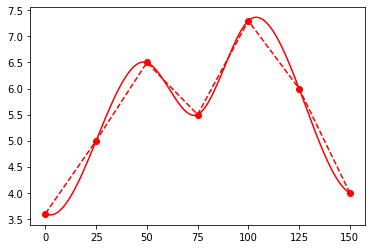

In [66]:
# Build an interpolating curve, parameterizing it by the angle
# from scipy.interpolate import make_interp_spline
spl = make_interp_spline(X, np.c_[X, Y])

# Evaluate the interpolant on a finer grid (note that we transpose 
# the result to unpack it into a pair of x- and y-arrays)
phi_new = np.linspace(X.min(), X.max(), 300)
x_new, y_new = spl(phi_new).T
plt.plot(X, Y, 'ro--')
plt.xticks(np.arange(X.min(), X.max()+1, 25.0));
plt.plot(x_new, y_new, 'r-');

## Filling the area under curve
https://stackoverflow.com/a/30580669/5820024

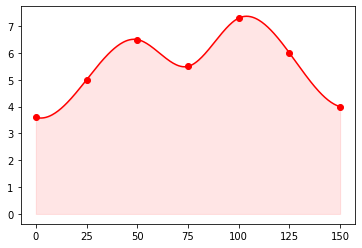

In [65]:

plt.plot(X, Y, 'ro')
plt.plot(x_new, y_new, 'r-');
plt.fill_between(x_new,y_new, alpha=0.1, color='r')
plt.xticks(np.arange(X.min(), X.max()+1, 25.0));

## Calculating area under curve for un-even spans

In [71]:
dt = np.array([[0, 3.6], [20, 5.], [45, 6.5], [60, 5.5], [100, 7.3],
                 [130, 6.0], [150, 4.0]])
dt

array([[0.000, 3.600],
       [20.000, 5.000],
       [45.000, 6.500],
       [60.000, 5.500],
       [100.000, 7.300],
       [130.000, 6.000],
       [150.000, 4.000]])

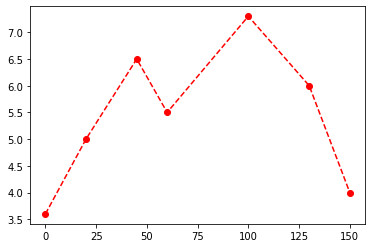

In [72]:
X, Y = dt[:,0], dt[:,1]
plt.xticks(np.arange(X.min(), X.max()+1, 25.0));
plt.plot(X, Y, 'ro--')

## Getting the function of area under curve
![From HYDRUS simulation](../Assets/area.png)

$$y = ax^2 + bx +c$$


$$area = \int_{-h}^{k}ax^2+bx+c $$


$$area = [\frac{a}{3}x^3+\frac{b}{2}x^2+cx]_{-h}^{k}$$


$$area = \frac{a}{3}((k)^3-(-h)^3)+\frac{b}{2}((k)^2-(-h)^2)+c((k)-(-h))$$


$$area = \frac{a}{3}(k^3+h^3)+\frac{b}{2}(k^2-h^2)+c(k+h)$$


$$a=\frac{h(y_2-y_1)-k(y_1-y_0)}{hk(k+h)}$$


$$b=\frac{h^2(y_2-y_1)+k^2(y_1-y_0)}{hk(k+h)}$$


$$c=y_1$$

In [73]:
def get_parabola_area(y0, y1, y2, h, k):
    '''
    Returns the area under curve of a parabola who's equation 
    $$y = ax^2 + bx +c$$
    from the point -h to k
    where -h crosses at y0
           0 crosses at y1
           k crosses at y2
    '''

    y21 = y2 - y1
    y10 = y1 - y0
    khd = k * h * (k + h)
    a = (h * y21 - k * y10) / khd
    b = (h * h * y21 + k * k * y10) / khd
    return a / 3 * (k**3 + h**3) + b / 2 * (k * k - h * h) + y1 * (k + h)

In [76]:
# Sample uniform data
data = np.array([[0, 3.6], [25, 5.], [50, 6.5]])
get_simpsons_area(data)

250.83333333333337

In [77]:
y0, y1, y2 = data[:, 1]
x0, x1, x2 = data[:, 0]
h, k = np.abs(x1 - x0), np.abs(x2 - x1)

get_parabola_area(y0, y1, y2, h, k)

250.83333333333334

# الحمد لله رب العالمين

## Generalizing the function to calculate all the area

In [98]:
data = np.array([[0, 3.6], [25, 5.], [50, 6.5], [75, 5.5], [100, 7.3],
                 [125, 6.0], [150, 4.0]])
area =[]
for i in range(1, data.shape[0]-1, 2):
    y0, y1, y2 = data[i - 1:i + 2, 1]
    x0, x1, x2 = data[i - 1:i + 2:, 0]
    h, k = np.abs(x1 - x0), np.abs(x2 - x1)
    part_area = get_parabola_area(y0, y1, y2, h, k)
    print(i, ": ", x0, y0, x1, y1, x2, y2, h, k, part_area)
    
    area.append(part_area)
print('\nThe Total area is: ', sum(area))

1 :  0.0 3.6 25.0 5.0 50.0 6.5 25.0 25.0 250.83333333333334
3 :  50.0 6.5 75.0 5.5 100.0 7.3 25.0 25.0 298.3333333333333
5 :  100.0 7.3 125.0 6.0 150.0 4.0 25.0 25.0 294.1666666666667

The Total area is:  843.3333333333333


In [110]:
# Create the function
def get_uneven_spans_area(data, show_steps=False):
    area = 0
    # n must be of odd number and >= 3
    n = data.shape[0]
    if n % 2 == 0:
        print (f"ERROR! The number of points must be odd.")
        print (f"You provided {n} rows and {data.shape[1]} columns")
        return None
    if n < 3:
        print (f"ERROR! The number of points must be >= 3. ")
        print (f"You provided {n} rows and {data.shape[1]} columns")
    for i in range(1, data.shape[0] - 1, 2):
        y0, y1, y2 = data[i - 1:i + 2, 1]
        x0, x1, x2 = data[i - 1:i + 2:, 0]
        h, k = np.abs(x1 - x0), np.abs(x2 - x1)
        part_area = get_parabola_area(y0, y1, y2, h, k)
        area += part_area
        if show_steps:
            print(i, ": ", x0, y0, x1, y1, x2, y2, h, k, part_area)
    return area

In [101]:
# test 1
get_uneven_spans_area(data, show_steps=True)

1 :  0.0 3.6 25.0 5.0 50.0 6.5 25.0 25.0 250.83333333333334
3 :  50.0 6.5 75.0 5.5 100.0 7.3 25.0 25.0 298.3333333333333
5 :  100.0 7.3 125.0 6.0 150.0 4.0 25.0 25.0 294.1666666666667


843.3333333333333

In [102]:
# Get the different spans area
get_uneven_spans_area(dt, show_steps=True)

1 :  0.0 3.6 20.0 5.0 45.0 6.5 20.0 25.0 230.625
3 :  45.0 6.5 60.0 5.5 100.0 7.3 15.0 40.0 323.2013888888889
5 :  100.0 7.3 130.0 6.0 150.0 4.0 30.0 20.0 306.1111111111111


859.9375

In [99]:
data.shape

(7, 2)

In [111]:
# Testing errors
get_uneven_spans_area(dt[:-1, :])

ERROR! The number of points must be odd.
You provided 6 rows and 2 columns


In [112]:
get_uneven_spans_area(dt[:2, :])

ERROR! The number of points must be odd.
You provided 2 rows and 2 columns


In [113]:
get_uneven_spans_area(dt[:5, :])

553.8263888888889